In [1]:
import numpy as np
import matplotlib.pyplot as plt
import neuron
from neuron import h, rxd,nrn
from neuron.units import ms, mV  #explicitly define our units
import math as m
from scipy.signal import find_peaks
import pandas as pd

In [2]:
#Include new mechanisms for additional channels 

h.nrn_load_dll('C:\\nrn\\Mod Files\\nrnmech.dll')

#h.load_file("nrnmech.dll")
h.load_file('stdrun.hoc') #loads in Neurons running domain

        

1.0

In [3]:
class Cortical_Neuron():
    # Class to create cortical neuron with relevant mechanisms and morphology

    def __init__(self, node_num=21, connect=1, connection_node=15):  # Electrode 1.5mm away, at centre of axon
        # Create topology
        self.connect = connect
        self.connection_node = connection_node
        self.node_num = node_num
        self.nodes = []
        self.myelins = []
        for i in range(node_num):
            self.nodes.append(h.Section(name=f"Node_{i}"))  # Create sections with names corresponding to nodes Node_0 Node_1
            self.myelins.append(h.Section(name=f"Myelins_{i}"))

        self.ais = h.Section(name='ais')
        self.collateral = h.Section(name='collateral')

        # Connect nodes and myelin into one long axon
        for i in range(node_num-1):
            self.nodes[i].connect(self.myelins[i], 1, 0)
            self.myelins[i+1].connect(self.nodes[i], 1, 0)

        self.nodes[node_num-1].connect(self.myelins[node_num-1], 1, 0)
        self.myelins[0].connect(self.ais, 1, 0)
        if connect == 1:
            self.collateral.connect(self.nodes[connection_node], 0.5, 0)

        # Initialise parameters
        Ena = 60
        Ek = -90
        v_init = -68
        rm = 30000
        celsius = 37
        ra = 150
        c_m = 0.8

        
        #Storing vectors 
        self.V_c_vectors = {} # Store collateral voltage vectors
        self.V_a_vectors = {}  # Store axon voltage vectors
        self.V_ais_vectors = {} # Store AIS voltage vectors
        self.Ext_potential = {} # Store collateral extracellular potential vectors
        self.Ext_potentialA = {} # Store collateral extracellular potential vectors
        self.Firing_Counter_Collateral = [] # Store collateral firing count vectors
        self.Firing_Times_Collateral = []
        self.Firing_Count_Collateral = []
        self.Firing_Counter_Axon = []
        self.Firing_Times_Axon = []
        self.Firing_Count_Axon = []
        self.Firing_Counter_AIS = []
        self.Firing_Times_AIS = []
        self.Firing_Count_AIS = []
        
        # Insert mechanisms and define geometries
        for n in self.nodes:
            n.L = 2
            n.diam = 1.2
            n.Ra = ra
            n.insert('cortical_axon_i_kd')
            n.insert('cortical_axon_i_kv')
            n.insert("cortical_axon_i_na")
            n.insert('cortical_axon_i_leak')
            n.insert(h.extracellular)
            #n.insert(h.APCount)
            n.g_Na_cortical_axon_i_na = 0.28
            n.g_Kd_cortical_axon_i_kd = 0.0072
            n.g_Kv_cortical_axon_i_kv = 0.0005
            n.g_l_cortical_axon_i_leak = 0.02
            n.ek = Ek
            n.ena = Ena
            n.cm = c_m
            n.nseg = 5

        for m in self.myelins:
            m.L = 500
            m.diam = 1.4
            m.Ra = ra
            m.cm = 0.04
            m.nseg = 11
            m.insert('cortical_axon_i_na')
            m.insert('cortical_axon_i_leak')
            m.g_Na_cortical_axon_i_na = 0.001
            m.g_l_cortical_axon_i_leak = 0
            m.ena = Ena
        self.myelins[0].L = 80

        self.ais.L = 20
        self.ais.nseg = 5
        self.ais.diam = 1.2
        self.ais.insert('cortical_axon_i_na')
        self.ais.insert('cortical_axon_i_kv')
        self.ais.insert('cortical_axon_i_kd')
        self.ais.insert('cortical_axon_i_leak')
        self.ais.insert(h.extracellular)
        self.ais.g_Kv_cortical_axon_i_kv = 0.002
        self.ais.g_Na_cortical_axon_i_na = 0.4
        self.ais.g_Kd_cortical_axon_i_kd = 0.015
        self.ais.g_l_cortical_axon_i_leak = 0.000033
        self.ais.Ra = ra
        self.ais.cm = c_m
        self.ais.ek = Ek
        self.ais.ena = Ena

        self.collateral.L = 500
        self.collateral.diam = 0.5
        self.collateral.nseg = 11
        self.collateral.Ra = ra
        self.collateral.cm = c_m
        self.collateral.insert('cortical_axon_i_na')
        self.collateral.insert('cortical_axon_i_kd')
        self.collateral.insert('cortical_axon_i_kv')
        self.collateral.insert('cortical_axon_i_leak')
        self.collateral.insert(h.extracellular)
        #self.collateral.insert(h.APCount)
        self.collateral.g_l_cortical_axon_i_leak= 0.000033
        self.collateral.g_Kd_cortical_axon_i_kd=0.0006  #changed from 0.0006 
        self.collateral.g_Na_cortical_axon_i_na= 0.13333
        self.collateral.g_Kv_cortical_axon_i_kv = 0.001
        self.collateral.ek = Ek
        self.collateral.ena = Ena

    @staticmethod
    def Euclidean(x1, x2, y1, y2):
        return m.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    def Coordinates(self, Electrode_X_d, Electrode_Y_d):
    
        # Axon Coords
        y_coords_A = []
        for n in range(self.node_num):
            if n == 0:
                y_coords_A.append(100 + 1)  # AIS + Myelin[0] + midpoint of node 0
            else:
                y_coords_A.append(100 + 500 * n + n * 2 + 1)  # AIS + initial myelin + num_myelin x n + nodes x node_length + 1 for centre of that node

        Node_radius = (self.nodes[0].diam) / 2
        X_A = Node_radius  # x coordinate of axon is radius of node
        r_A = []  # euclidean distance for the axon

        for n in range(self.node_num):
            r_A.append(Cortical_Neuron.Euclidean(X_A, Electrode_X_d, y_coords_A[n], Electrode_Y_d))

        # Collateral Coords
        x_coords_C = []
        C_L = self.collateral.L
        Nseg_C = self.collateral.nseg
        for seg in range(Nseg_C):
            x_coords_C.append((seg / Nseg_C) * C_L + Node_radius)  # collateral length

        Collateral_YPosition = 100 + 500 * self.connection_node + self.connection_node * 2 + 1  # assume collateral attached at the centre of the node - 15
        r_C = []
        for seg in range(Nseg_C):
            r_C.append(Cortical_Neuron.Euclidean(x_coords_C[seg], Electrode_X_d, Collateral_YPosition, Electrode_Y_d))

        # AIS coords
        Nseg_AIS  = self.ais.nseg
        AIS_L = self.ais.L
        X_AIS = Node_radius
        y_coords_AIS = []
        for seg in range(Nseg_AIS):
            y_coords_AIS.append((seg / Nseg_AIS) * AIS_L)

        r_AIS = []
        for seg in range(Nseg_AIS):
            r_AIS.append(Cortical_Neuron.Euclidean(X_AIS, Electrode_X_d, y_coords_AIS[seg], Electrode_Y_d))
            
        # conversion factor
        for i in range(len(r_A)):
            r_A[i] *= 10**-6

        for i in range(len(r_C)):
            r_C[i] *= 10**-6

        for i in range(len(r_AIS)):
            r_AIS[i] *= 10**-6
            
        return r_A, r_C, r_AIS, y_coords_A, x_coords_C, Node_radius, Collateral_YPosition, Electrode_X_d, Electrode_Y_d

    def Plot_Geometry(self, Electrode_X_d=1500, Electrode_Y_d=521):
        [r_A, r_C, r_AIS, y_coords_A, x_coords_C, Node_radius, Collateral_YPosition, Electrode_X_d, Electrode_Y_d] = self.Coordinates(Electrode_X_d, Electrode_Y_d)
        # Plot coordinates of Electrode, collateral and axon with respect to y and x axis:
        y_coords_C = []
        x_coords_A = []
        for i in range(len(x_coords_C)):
            y_coords_C.append(Collateral_YPosition)

        for i in range(len(y_coords_A)):
            x_coords_A.append(Node_radius)

        stim_x = Electrode_X_d
        stim_y = Electrode_Y_d
        #plt.plot(x_coords_C, y_coords_C, '--', color='red', label='Collateral Position')
        #plt.plot(x_coords_A, y_coords_A, color='blue', label='Axon Position')
        #plt.plot(stim_x, stim_y, '*', color='black', label='Electrode Position')
        # plt.title('Relative position of axon, collateral and electrode')
        # plt.xlabel('X (um)')
        # plt.ylabel('Y (um)')
        # plt.legend()
        # plt.grid(True)
        # plt.show()
        return x_coords_C,y_coords_C, x_coords_A, y_coords_A

    def Extracellular(self, amp_A, amp_C, delay, pulse_dur, total_dur, Electrode_X_d=1500, Electrode_Y_d=521):
        [r_A, r_C, r_AIS, y_coords_A, x_coords_C, Node_radius, Collateral_YPosition, Electrode_X_d, Electrode_Y_d] = self.Coordinates(Electrode_X_d, Electrode_Y_d)
        pi = 3.141
        sigma = 0.2  # S/m
        Phi_A = []
        for i in range(len(r_A)):
            Phi_A.append((amp_A / (r_A[i] * sigma * pi * 4))*10**3)

        Phi_C = []
        for i in range(len(r_C)):
            Phi_C.append((amp_C / (r_C[i] * sigma * pi * 4))*10**3)

        Phi_AIS = []
        for i in range(len(r_AIS)):
            Phi_AIS.append((amp_A / (r_AIS[i] * sigma * pi * 4))*10**3)


        # Time vector
        t0 = 0
        t1 = delay
        t2 =delay
        t3 = delay + pulse_dur
        t4 = delay + pulse_dur
        t5 = total_dur  # 15ms
        stimtvec_list_A = [t0, t1, t2, t3, t4, t5]
        stimtvec_A = h.Vector(stimtvec_list_A)

        stimtvec_list_C = [t0, t1, t2, t3, t4, t5]
        stimtvec_C = h.Vector(stimtvec_list_C)

        stimtvec_list_AIS = [t0, t1, t2, t3, t4, t5]
        stimtvec_AIS = h.Vector(stimtvec_list_AIS)

        # Play in ex mechanisms

        #Collateral
        Nseg_C = self.collateral.nseg
        ampvec_allnodes_C = []
        for i in range(Nseg_C):
            loc = i / Nseg_C
            stimampvec_list_C = [0, 0, Phi_C[i], Phi_C[i], 0, 0]
            ampvec_allnodes_C.append(h.Vector(stimampvec_list_C))
            ampvec_allnodes_C[-1].play(self.collateral(loc)._ref_e_extracellular, stimtvec_C, True)
           # print(f"{i}: {stimampvec_list_C}")

        #Axon
        ampvec_allnodes_A = []
        for n in range(self.node_num):
            stimampvec_list_A = [0, 0, Phi_A[n], Phi_A[n], 0, 0]
            ampvec_allnodes_A.append(h.Vector(stimampvec_list_A))
            ampvec_allnodes_A[-1].play(self.nodes[n](0.5)._ref_e_extracellular, stimtvec_A, True)
            #print(f"Axon {n}: {stimampvec_list_A}")
        


        #AIS
        Nseg_AIS  = self.ais.nseg
        ampvec_allnodes_AIS = []
        for i in range(Nseg_AIS):
            loc = i / Nseg_AIS
            stimampvec_list_AIS = [0, 0, Phi_AIS[i], Phi_AIS[i], 0, 0]
            ampvec_allnodes_AIS.append(h.Vector(stimampvec_list_AIS))
            ampvec_allnodes_AIS[-1].play(self.ais(loc)._ref_e_extracellular, stimtvec_AIS, True)
            #print(f"AIS {i}: {stimampvec_list_AIS}")


        return ampvec_allnodes_A, ampvec_allnodes_C, ampvec_allnodes_AIS, stimtvec_A, stimtvec_C, stimtvec_AIS

    def Insert_Counter_Collateral(self, seg_index, threshold):
        loc = seg_index / self.collateral.nseg
        apc = h.APCount(self.collateral(loc))
        apc.thresh = threshold
        self.Firing_Counter_Collateral.append(apc)

    def Insert_Counter_Axon(self, node_index, threshold):
        apc2 = h.APCount(self.nodes[node_index](0.5))
        apc2.thresh = threshold
        self.Firing_Counter_Axon.append(apc2)

    def Insert_Counter_AIS(self, seg_index, threshold):
        loc = seg_index / self.ais.nseg
        apc = h.APCount(self.ais(loc))
        apc.thresh = threshold
        self.Firing_Counter_AIS.append(apc)

    def get_Fire_count_collateral(self, seg_index):
        try:
            apc = self.Firing_Counter_Collateral[seg_index]
            Count = apc.n
            if Count > 0:
                fire_times = apc.time
            else:
                fire_times = [np.nan]  # Use NaN to indicate no firing times
        except IndexError:
            # Handle missing counter by setting Count to 0 and fire_times to NaN
            Count = 0
            fire_times = [np.nan]
        finally:
            self.Firing_Count_Collateral.append(Count)
            self.Firing_Times_Collateral.append(fire_times)

    def get_Fire_count_Axon(self, node_index):
        try:
            apc = self.Firing_Counter_Axon[node_index]
            Count = apc.n
            if Count > 0:
                fire_times = apc.time
            else:
                fire_times = [np.nan]  # Use NaN to indicate no firing times
        except IndexError:
            # Handle missing counter by setting Count to 0 and fire_times to NaN
            Count = 0
            fire_times = [np.nan]
        finally:
            self.Firing_Count_Axon.append(Count)
            self.Firing_Times_Axon.append(fire_times)

    def get_Fire_count_AIS(self, seg_index):
        try:
            apc = self.Firing_Counter_AIS[seg_index]
            Count = apc.n
            if Count > 0:
                fire_times = apc.time
            else:
                fire_times = [np.nan]  # Use NaN to indicate no firing times
        except IndexError:
            # Handle missing counter by setting Count to 0 and fire_times to NaN
            Count = 0
            fire_times = [np.nan]
        finally:
            self.Firing_Count_AIS.append(Count)
            self.Firing_Times_AIS.append(fire_times)
            
    def Record_time(self):
        t = h.Vector().record(h._ref_t)
        return t

    def record_ex_potential(self, seg_index):
        loc = seg_index/self.collateral.nseg
        vc_EX = h.Vector()
        vc_EX.record(self.collateral(loc)._ref_e_extracellular)
        self.Ext_potential[seg_index]=vc_EX

    def record_ex_potentialA(self, node_index):
        va_EX = h.Vector()
        va_EX.record(self.nodes[node_index](0.5)._ref_e_extracellular)
        self.Ext_potentialA[node_index]=va_EX
                                

    def record_voltage_collateral(self,seg_index):
        # Records the voltage but does not return it
        loc = seg_index/self.collateral.nseg
        v_vec = h.Vector() 
        v_vec.record(self.collateral(loc)._ref_v)
        self.V_c_vectors[seg_index]=v_vec

    def record_voltage_axon(self, node_index):
        # Records the voltage but does not return it
        v_vec2 = h.Vector() 
        v_vec2.record(self.nodes[node_index](0.5)._ref_v)
        self.V_a_vectors[node_index]=v_vec2

    def record_voltage_AIS(self,seg_index):
        # Records the voltage but does not return it
        loc = seg_index/self.ais.nseg
        v_vec3 = h.Vector() 
        v_vec3.record(self.ais(loc)._ref_v)
        self.V_ais_vectors[seg_index]=v_vec3


    def get_voltage_collateral(self, seg_index):
        # Retrieves recorded voltage data for collateral
        return np.array(self.V_c_vectors[seg_index])
        
    def get_voltage_axon(self,node_index):
        # Retrieves recorded voltage data for axon
        return np.array(self.V_a_vectors[node_index])

    def get_voltage_AIS(self, seg_index):
        # Retrieves recorded voltage data for collateral
        return np.array(self.V_ais_vectors[seg_index])


    def get_ex_collateral(self, seg_index):
        # Retrieves recorded voltage data for collateral
        return np.array(self.Ext_potential[seg_index])

    def get_ex_axon(self, node_index):
        # Retrieves recorded voltage data for collateral
        return np.array(self.Ext_potentialA[node_index])

    def get_order_of_excitation(self, array):
        # Creating a list of tuples (value, index) for each element in the array
        indexed_array = [(value, index) for index, value in enumerate(array)]
        # Sorting the list of tuples by value
        sorted_indexed_array = sorted(indexed_array, key=lambda x: x[0])
        # Creating an empty list to store the sorted indices
        order_of_excitation = []
        # Extracting the indices from the sorted list of tuples and appending to the list
        for value, index in sorted_indexed_array:
            order_of_excitation.append(index)
        # Return the list of indices representing the order of excitation
        return order_of_excitation
    
    def find_spikes(self, voltage_trace, times, height_threshold, min_prominence):
        # Use find_peaks to detect potential spikes based on the height_threshold
        initial_spike_indices, _ = find_peaks(voltage_trace, height=height_threshold, prominence=min_prominence)
        #print(f"Initial spikes found: {initial_spike_indices}")
    
        # Filter detected spikes to ensure a positive gradient at threshold crossing
        validated_spike_indices = []
        for i in initial_spike_indices:
            # Ensure bounds for comparison, check for positive gradient, and filter out artifacts > 70 mV
            if i > 0 and i < len(voltage_trace) - 1:
                if voltage_trace[i-1] < voltage_trace[i] > voltage_trace[i+1] and voltage_trace[i] <= 70: # ensure spike isn't stimulus artefact <70mV
                    validated_spike_indices.append(i)
        
        #print(f"Validated spikes (pass gradient and <70mV check): {validated_spike_indices}")
    
        # Convert indices to times using a list comprehension
        spike_times = [times[i] for i in validated_spike_indices] if validated_spike_indices else [np.nan]
        spike_count = len(validated_spike_indices)
        
        print(f"Spike count: {spike_count}, Spike times: {spike_times}")
    
        # Handle non-firing cases by ensuring spike_times is [np.nan] and spike_count is 0 if no spikes are found
        return spike_times, spike_count


 


In [4]:
def plot_initial_electrode_positions_with_geometry(electrode_y_positions, initial_x_position=50):
    # Create a temporary instance of Cortical_Neuron for geometry calculations
    temp_neuron = Cortical_Neuron(node_num=11, connect=1, connection_node=9)
    
    plt.figure(figsize=(10, 7))
    for y_pos in electrode_y_positions:
        # Use the Coordinates method to calculate geometry data for plotting
        [r_A, r_C, y_coords_A, x_coords_C, Node_radius, Collateral_YPosition, Electrode_X_d, Electrode_Y_d] = temp_neuron.Coordinates(initial_x_position, y_pos)
        
        # Plot collateral positions
        plt.plot(x_coords_C, [Collateral_YPosition]*len(x_coords_C), '--', color='red', label='Collateral' if y_pos == electrode_y_positions[0] else "")
        # Plot axon positions
        plt.plot([Node_radius]*len(y_coords_A), y_coords_A, color='red', label='Axon' if y_pos == electrode_y_positions[0] else "")
        # Plot initial electrode position
        plt.scatter(initial_x_position, y_pos, color='black', label=f'Initial Electrode Y={y_pos}', zorder=5)

    plt.title('Initial Electrode Positions and Neuron Geometry')
    plt.xlabel('X (um)')
    plt.ylabel('Y (um)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [5]:
a= 50
b = 507.894737
c =1042.105263
d= 1423.684211
c1 =-0.00010060424804687500
c2 = -0.00029094238281250000
c3 =-0.00055983276367187500
c4 =-0.00075500488281250000



Collateral- Firing occurred 2.0 times at: 92.32500000001242, for segment 0
Collateral- Firing occurred 2.0 times at: 92.47500000001246, for segment 1
Collateral- Firing occurred 2.0 times at: 92.6500000000125, for segment 2
Collateral- Firing occurred 1.0 times at: 92.80000000001253, for segment 3
Collateral- Firing occurred 1.0 times at: 92.97500000001257, for segment 4
Collateral- Firing occurred 1.0 times at: 93.15000000001261, for segment 5
Collateral- Firing occurred 1.0 times at: 93.32500000001265, for segment 6
Collateral- Firing occurred 1.0 times at: 93.50000000001269, for segment 7
Collateral- Firing occurred 1.0 times at: 93.67500000001273, for segment 8
Collateral- Firing occurred 1.0 times at: 93.82500000001276, for segment 9
Collateral- Firing occurred 1.0 times at: 93.92500000001279, for segment 10
Axon- Firing occurred 2.0 times at: 80.85000000000981, for node 0
Axon- Firing occurred 2.0 times at: 81.2000000000099, for node 1
Axon- Firing occurred 2.0 times at: 81.57500

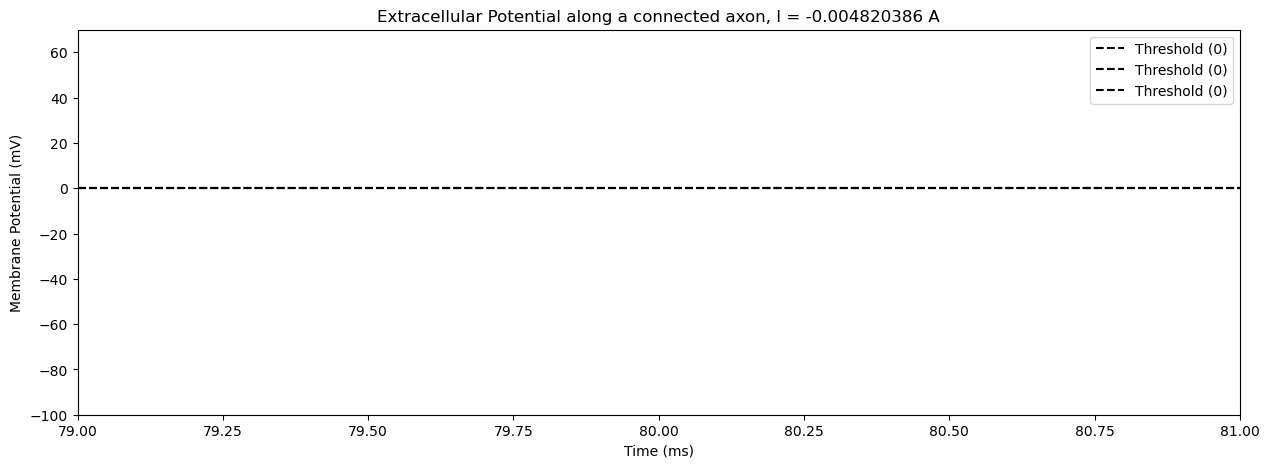

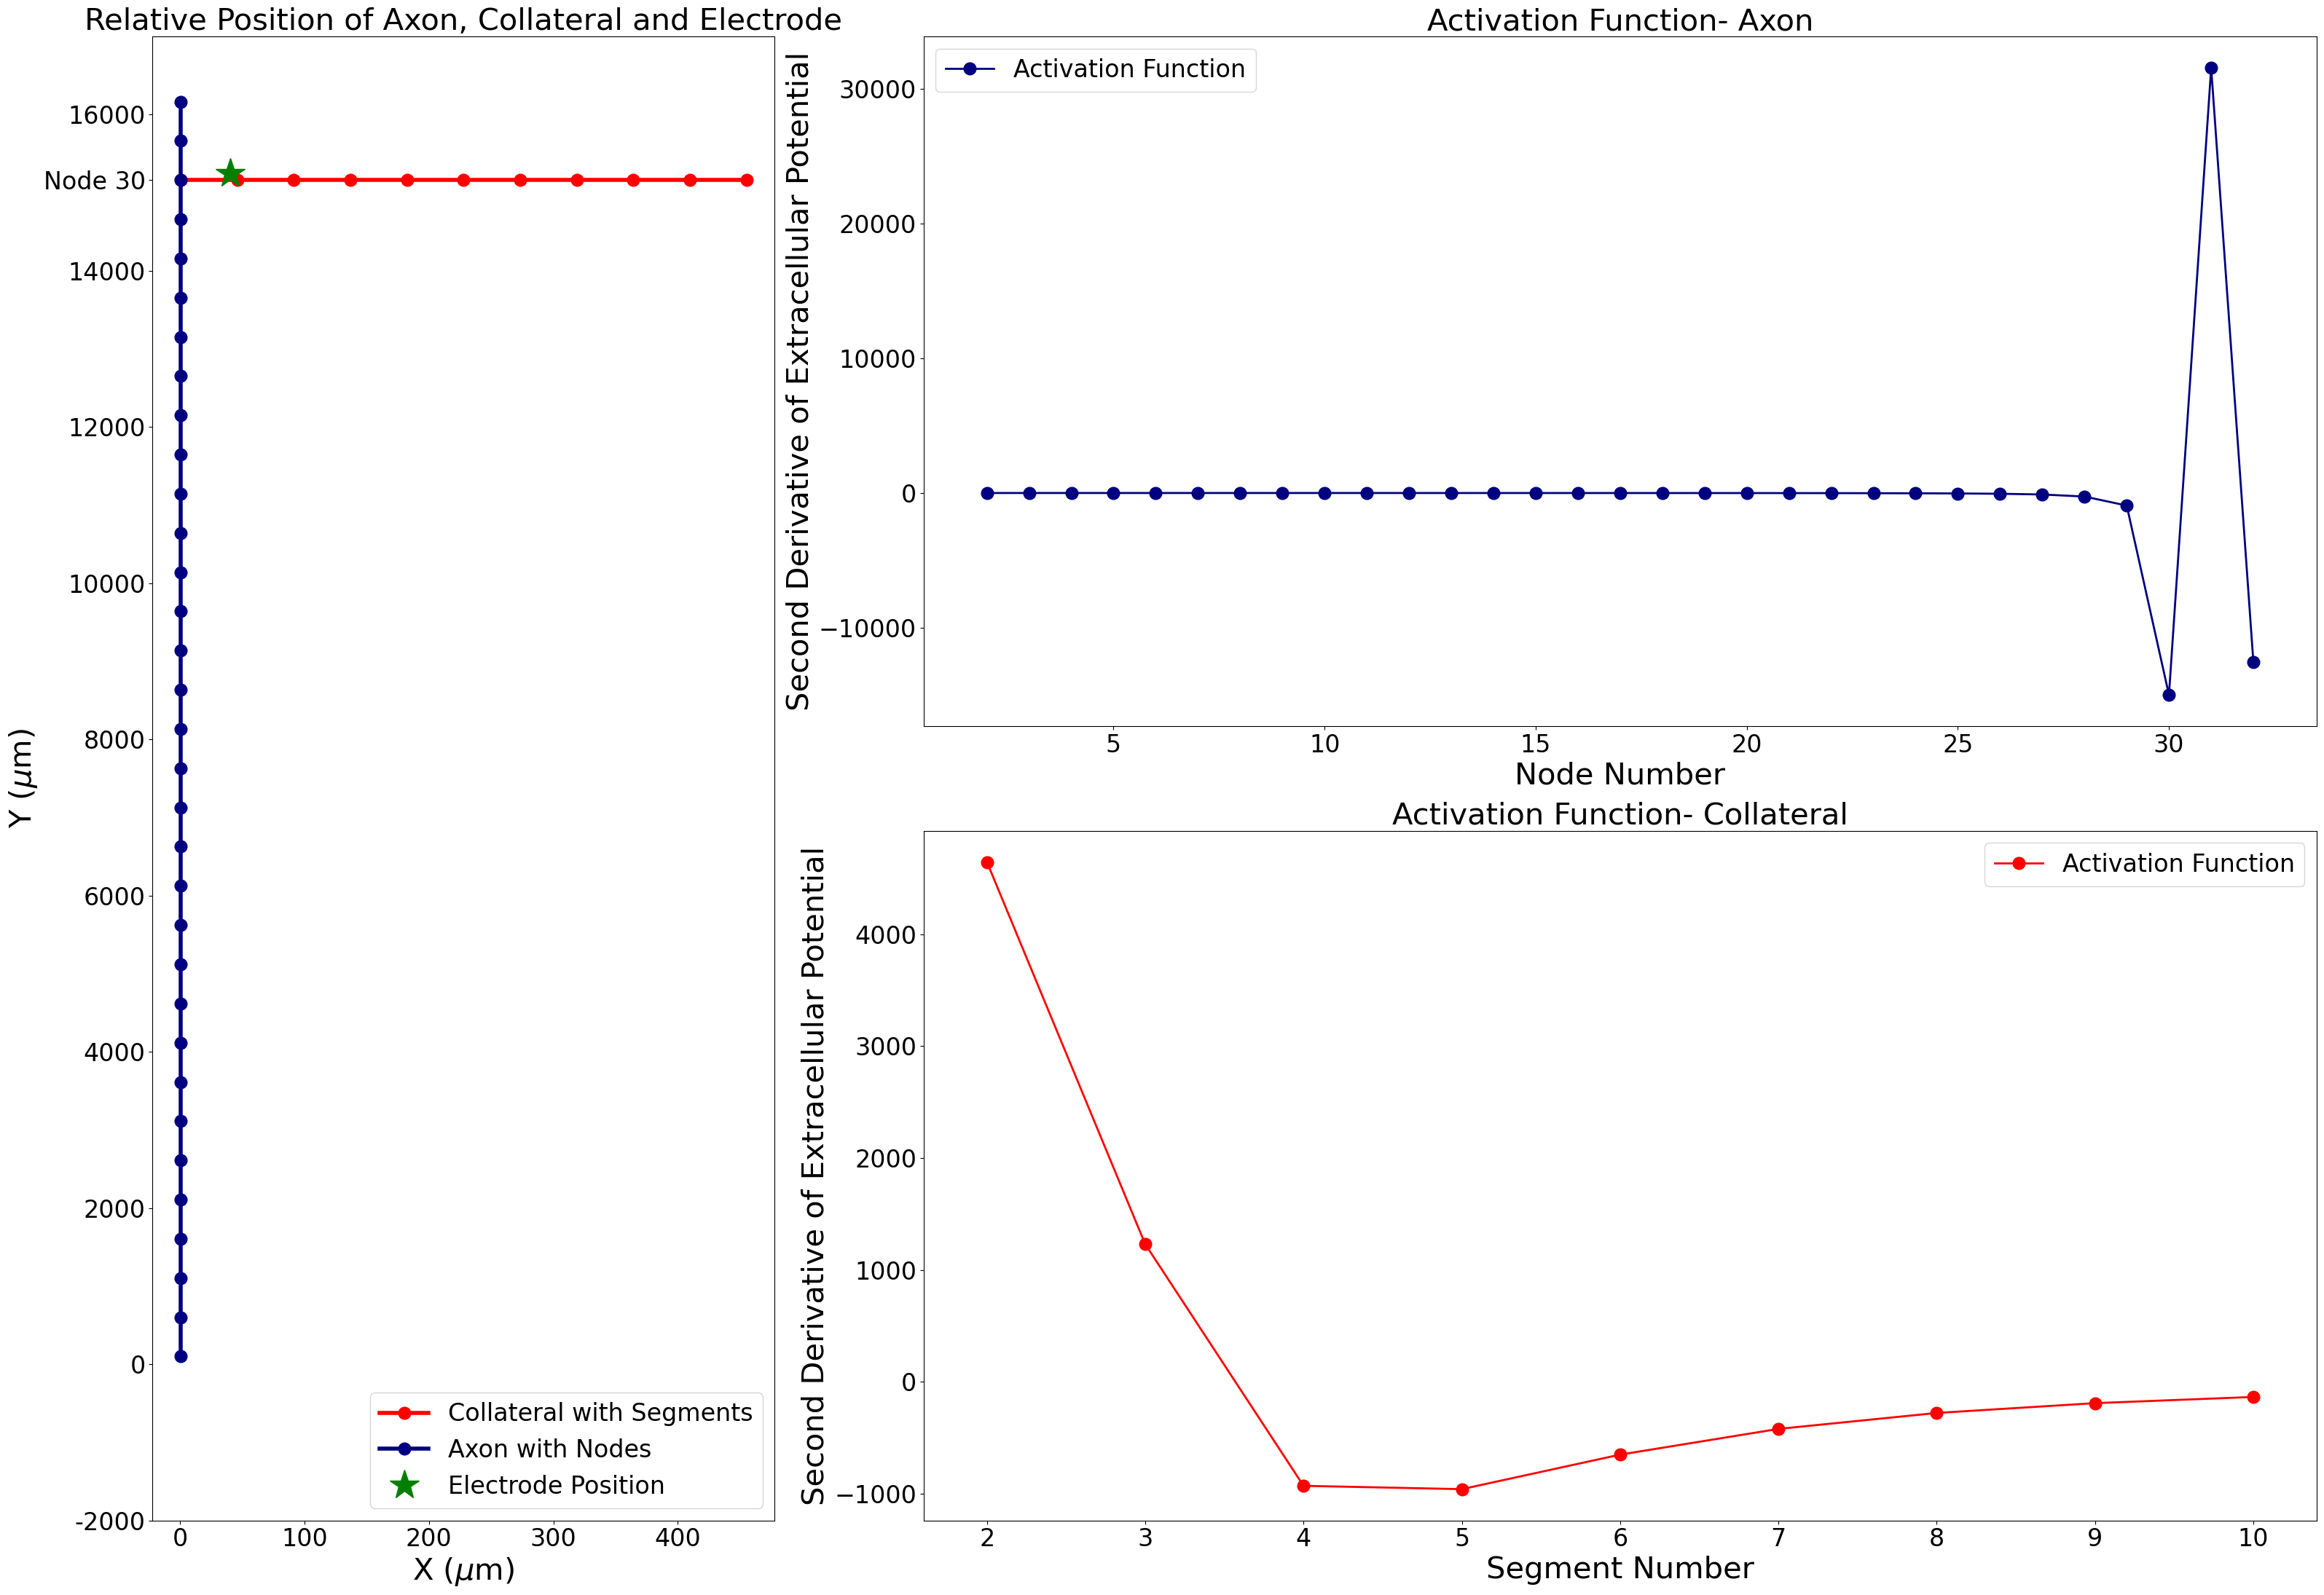

In [6]:
import matplotlib.cm as cm
#Simulation set up
h.tstop =100 #simulation duration t1 +pulse_dur + t5, delay = 80 ms
h.celsius = 37 #temperature (in celsius)
h.finitialize(-68) #initialise simulation 
node_num=33
Nseg_C = 11
Nseg_AIS =5
connect = 1
connection_node= 30
cur = -0.004820386
amp_A=cur
amp_C=cur
delay=80
pulse_dur=60*(10**-3)
total_dur=100
Electrode_X_d=40
Electrode_Y_d=15250
TH=0
C = Cortical_Neuron(node_num, connect,  connection_node)
[ampvec_allnodes_A, ampvec_allnodes_C, ampvec_allnodes_AIS, stimtvec_A, stimtvec_C, stimtvec_AIS] = C.Extracellular(amp_A, amp_C, delay, pulse_dur, total_dur, Electrode_X_d, Electrode_Y_d)
min_prominence = 10 #10mV
t = C.Record_time()
for i in range(node_num):
    C.record_voltage_axon(i)
    C.record_ex_potentialA(i)
    C.Insert_Counter_Axon(i,TH)

for j in range(Nseg_C):
    C.record_voltage_collateral(j)
    C.record_ex_potential(j)
    C.Insert_Counter_Collateral(j, TH)

for k in range(Nseg_AIS):
    C.record_voltage_AIS(k)
    C.Insert_Counter_AIS(k, TH)
     
plt.figure(figsize=(15, 5))
[x_coords_C,y_coords_C, x_coords_A, y_coords_A] = C.Plot_Geometry(Electrode_X_d, Electrode_Y_d)

# # Create a DataFrame
# df_Axon = pd.DataFrame({'Axon_X': x_coords_A, 'Axon_Y': y_coords_A})
# df_Collateral = pd.DataFrame({'Collateral_X': x_coords_C, 'Collateral_Y': y_coords_C})
# # Concatenate DataFrames 
# df_Coords = pd.concat([df_Axon, df_Collateral], axis=1)
# #save to excel
# excel_path = "C:\\Users\\laura\\Documents\\NEURON Code\\Python interfaced Neuron\\Diameter_axon_collateral_Coordinates.xlsx"  # Adjust path for your environment
# df_Coords.to_excel(excel_path, index=False)


#Run the simulation
h.run()

for i in range(node_num):
    C.get_Fire_count_Axon(i)

for j in range(Nseg_C):
    C.get_Fire_count_collateral(j)

for k in range(Nseg_AIS):
    C.get_Fire_count_AIS(k)

colors = cm.rainbow(np.linspace(0, 1, Nseg_C))  # Create a list of colors
labels = [f'Voltage at {seg/Nseg_C:.2f}' for seg in range(Nseg_C)]  # List of labels


#plt.figure(figsize=(15, 5))
for seg in range(Nseg_C):
    vc = C.get_voltage_collateral(seg)  # Corrected from i to seg
    #plt.plot(t, vc, color=colors[seg], label=labels[seg])
    spike_count = C.Firing_Count_Collateral[seg]
    spike_times = C.Firing_Times_Collateral[seg]
    if spike_count == 0:
        print("No firing occurred.")
    else:
        print(f"Collateral- Firing occurred {spike_count} times at: {spike_times}, for segment {seg}")
        
plt.axhline(y=TH, color='black', linestyle='--', label=f'Threshold ({TH})')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title(f'AP for Cortical Neuron, with extracellular stimulus, recording along a disconnected collateral, I = {amp_C} A') 
plt.legend(loc='upper right')
plt.xlim([78, 85])
plt.ylim([-100, 70])

colors2 = cm.rainbow(np.linspace(0, 1, node_num))  # Create a list of colors
labels2 = [f'Voltage at Node {n}' for n in range(node_num)]  # List of labels

#plt.figure(figsize=(15, 5))
for n in range(node_num):
    va = C.get_voltage_axon(n) 
    #plt.plot(t, va, color=colors2[n], label=labels2[n])
    spike_count = C.Firing_Count_Axon[n]
    spike_times = C.Firing_Times_Axon[n]
    if spike_count == 0:
        print("No firing occurred.")
    else:
        print(f"Axon- Firing occurred {spike_count} times at: {spike_times}, for node {n}")
        
plt.axhline(y=TH, color='black', linestyle='--', label=f'Threshold ({TH})')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title(f'AP for Cortical Neuron, with extracellular stimulus, recording along a connected axon, I = {amp_A} A') 
plt.legend(loc='upper right')
plt.xlim([78, 85])
plt.ylim([-100, 70])

#plt.figure(figsize=(15, 5))
for seg in range(Nseg_AIS):
    vais = C.get_voltage_AIS(seg)  # Corrected from i to seg
    #plt.plot(t, vais, color=colors[seg], label=labels[seg])
    spike_count = C.Firing_Count_AIS[seg]
    spike_times = C.Firing_Times_AIS[seg]
    if spike_count == 0:
        print("No firing occurred.")
    else:
        print(f"AIS- Firing occurred {spike_count} times at: {spike_times}, for segment {seg}")
        
plt.axhline(y=TH, color='black', linestyle='--', label=f'Threshold ({TH})')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title(f'AP for Cortical Neuron, with extracellular stimulus, recording along AIS, I = {amp_C} A') 
plt.legend(loc='upper right')
plt.xlim([78, 85])
plt.ylim([-100, 70])

#plt.figure(figsize=(15, 5))
for seg in range(Nseg_C):
    vc_ex = C.get_ex_collateral(seg)  
    #plt.plot(t, vc_ex, color=colors[seg], label=labels[seg])

plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title(f'Extracellular Potential along a connected collateral, I = {amp_C} A') 
plt.legend(loc='upper right')
plt.xlim([79, 81])

Ee_collateral = []
#plt.figure(figsize=(15, 5))
for seg in range(Nseg_C):
    vc_ex = C.get_ex_collateral(seg)  
    #plt.plot(t, vc_ex, color=colors[seg], label=labels[seg])
    Ee_collateral.append(vc_ex)

plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title(f'Extracellular Potential along a connected collateral, I = {amp_C} A') 
plt.legend(loc='upper right')
plt.xlim([79, 81])

# Convert stim time (80 ms) to sample
tn = 3201

ev = np.array([e[tn] for e in Ee_collateral])
# Second derivative of the extracellular potential Activation function
# Calculate the second derivative of the extracellular potential for the collateral
second_derivative_collateral = np.diff(np.diff(ev))

# # Plotting the Activation Function along the collateral
# plt.figure(figsize=(15, 5))
# plt.plot(np.arange(2, 11), second_derivative_collateral, ".-")  # Adjust indices from 2 to 10
# plt.title('Plotting the Activation Function along the collateral')
# plt.xlabel('Segment number')
# plt.ylabel('Second derivative of Extracellular Potential')
# plt.legend(["Activation Function"], loc='upper right')
# plt.show()


#Apply same implementation to axon: 
####extracellular potential and activation function 

Ee_axon = []
#plt.figure(figsize=(15, 5))
for i in range(node_num):
    va_ex = C.get_ex_axon(i)  
    #plt.plot(t, va_ex, color=colors2[i], label=labels2[i])
    Ee_axon.append(va_ex)

plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title(f'Extracellular Potential along a connected axon, I = {amp_A} A') 
plt.legend(loc='upper right')
plt.xlim([79, 81])

# Convert stim time (80 ms) to sample
tn = 3201

ev = np.array([e[tn] for e in Ee_axon])
# Calculation of the second derivative of the extracellular potential
second_derivative = np.diff(np.diff(ev))

# # Plotting the Activation Function along the axon
# plt.figure(figsize=(15, 5))
# plt.plot(np.arange(2, 33), second_derivative, ".-")  # Adjusting indices from 2 to 32
# plt.title('Plotting the Activation Function along the axon')
# plt.xlabel('Node number')
# plt.ylabel('Second derivative of Extracellular Potential')
# plt.legend(["Activation Function"], loc='upper right')
# plt.show()

print(len(Ee_axon))
print(len(ev))  # Should initially be 33 for nodes 0 to 32
print(len(np.diff(ev)))  # Expect 32, for nodes 1 to 32
print(len(np.diff(np.diff(ev))))  # Expect 31, for nodes 1 to 31



# Set up the figure and subplots
fig = plt.figure(figsize=(32, 22))

# First column, one long vertical plot
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2)
ax1.plot(x_coords_C, y_coords_C,  marker= 'o', markersize= 12, linestyle='-', linewidth=4, color='red', label='Collateral with Segments')
ax1.plot(x_coords_A, y_coords_A, marker= 'o', markersize= 12, linestyle='-', linewidth=4, color='navy', label='Axon with Nodes')
ax1.plot(Electrode_X_d, Electrode_Y_d, '*', markersize=30, color='green', label='Electrode Position')


node_30_index = 0
if node_30_index < len(y_coords_C):
    node_30_y = y_coords_C[node_30_index]
    # Add custom tick for Node 30
    existing_ticks = ax1.get_yticks().tolist()  # Get existing y-ticks
    existing_ticks.append(node_30_y)  # Add the y-coordinate of Node 30
    ax1.set_yticks(existing_ticks)  # Set the new list of y-ticks
    ax1.set_yticklabels([f"{ytick:.0f}" if ytick != node_30_y else "Node 30" for ytick in existing_ticks])

ax1.set_title('Relative Position of Axon, Collateral and Electrode', fontsize=30)
ax1.set_xlabel('X ($\mu$m)', fontsize=30)
ax1.set_ylabel('Y ($\mu$m)', fontsize=30)
current_lower_limit, _ = ax1.get_ylim()  # Get the current lower limit of y-axis
ax1.set_ylim(current_lower_limit, 17000)  
ax1.tick_params(labelsize=24)
ax1.legend(loc='lower right',fontsize=24)

# Second column, first row
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=2)
ax2.plot(np.arange(2, 33), second_derivative, marker= 'o', markersize= 12, linestyle='-', linewidth=2, color='navy', label="Activation Function")
ax2.set_title('Activation Function- Axon', fontsize=30)
ax2.set_xlabel('Node Number', fontsize=30)
ax2.set_ylabel('Second Derivative of Extracellular Potential', fontsize=30)
ax2.legend(loc='upper left', fontsize=24)
ax2.tick_params(labelsize=24)

# Second column, second row
ax3 = plt.subplot2grid((2, 3), (1, 1), colspan=2)
ax3.plot(np.arange(2, 11), second_derivative_collateral,marker= 'o', markersize= 12, linestyle='-', linewidth=2, color='red', label="Activation Function")
ax3.set_title('Activation Function- Collateral', fontsize=30)
ax3.set_xlabel('Segment Number', fontsize=30)
ax3.set_ylabel('Second Derivative of Extracellular Potential', fontsize=30)
ax3.legend(loc='upper right', fontsize=24)
ax3.tick_params(labelsize=24)

plt.tight_layout()
# file_path2 = r"C:\Users\laura\Documents\NEURON Code\Python interfaced Neuron\Electrode_distance_threshold_plots\AF_Cathodal_high_thresh.png"
# plt.savefig(file_path2)
del C